# Comparing reducing dimension to moderate or low via PCA

Supporting code for the paper titled [Discovering latent topology and geometry in data: a law of large dimension](https://arxiv.org/abs/2208.11665). Further details and any references in the notebook to theorems, assumptions, etc. can be found there. 

## Package load

In [1]:
import numpy as np
import pandas as pd

from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE


from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')

plt.rcParams['figure.figsize'] = [9,5] #globally set figure size
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':8,
         'ytick.labelsize':8}
plt.rcParams.update(params)

from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
import os

%matplotlib inline

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package wordnet to /home/ag16115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In [2]:
def pc_scores(X, r, return_eig = None):
    U, s, Vh = sparse.linalg.svds(X,k=r)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    if return_eig is not None:
        return Y, s
    else:
        return Y

In [3]:
def clean_text(text):
    return " ".join([ Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split() if word not in stopword])  

In [4]:
def del_email_address(text):
    e = '\S*@\S*\s?'
    pattern = re.compile(e)
    return pattern.sub('', text) 

## LMS model and PC scores

<div class="alert alert-block alert-success">
<b>Latent Metric Space model:</b>
The data matrix $\mathbf{Y}\in\mathbb{R}^{n\times p}$ is defined by:
\begin{equation}
\mathbf{Y}_{ij} := X_{j}(Z_{i})+\sigma\mathbf{E}_{ij}\label{eq:model}
\end{equation}
for some $\sigma\geq0$. 
</div>

Where, 
* **Latent variables:** $Z_{1},\ldots,Z_{n}$ are random elements of a compact metric space $(\mathcal{Z},d_{\mathcal{Z}})$, i.i.d. according to a Borel probability measure $\mu$ supported on $\mathcal{Z}$. 
* **Random fields:** $X_{1},\ldots,X_{p}$ are independent but not necessarily identically distributed, $\mathbb{R}$-valued and square-integrable random fields, each with index set $\mathcal{Z}$. That is, for each $z\in\mathcal{Z}$ and $j=1,\ldots,p$, $X_{j}(z)$ is an $\mathbb{R}$-valued random variable such that $\mathbb{E}[|X_{j}(z)|^{2}]<\infty$.
* **Noise:** $\mathbf{E}\in\mathbb{R}^{p\times n}$ is a matrix of random variables whose elements are each zero-mean and unit-variance. The columns of $\mathbf{E}$ are assumed independent and elements in distinct rows of $\mathbf{E}$ are assumed pairwise uncorrelated.
***

<div class="alert alert-block alert-success">
<b>PC scores:</b> For data matrix $Y \in \mathbb{R}^{n\times p}$ the PC scores are defined by:
$$[\zeta_1| \dots | \zeta_n]^\top = \mathbf{Y} \mathbf{V}_{\mathbf{Y}} = p^{1/2} \mathbf{U}_{\mathbf{Y}} \boldsymbol{\Lambda}_{\mathbf{Y}} ^{1/2}. $$
where $\boldsymbol{\Lambda}_{\mathbf{Y}}\in\mathbb{R}^{r\times r}$
is the diagonal matrix whose diagonal elements are the $r$ largest eigenvalues of $p^{-1}\mathbf{Y}\mathbf{Y}^{\top}$, and the columns
of $\mathbf{U}_{\mathbf{Y}}\in\mathbb{R}^{n\times r}$ are orthonormal
eigenvectors associated with these eigenvalues and $\mathbf{V}_{\mathbf{Y}}\in\mathbb{R}^{p\times r}$ are orthonormal eigenvectors associated with the $r$ largest eigenvalues of $\mathbf{Y}^{\top}\mathbf{Y}$.
</div>

***

# Introduction

We explore the results of applying PCA to two datasets: images of a rotating car (https://aloi.science.uva.nl/) and the newsgroup data which  comprises around 18000 newsgroups posts on 20 topics (https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

# PCA: Car image example

In some situations, such as image analysis, embedded manifold structure in data can be explained intuitively in terms of the physical mechanism which generated the data.
We can account for the variation across the collection of images using far fewer dimensions, in terms of the position of the camera in the three-dimensional space
of the world around us. We explore the result of using principal component analysis (PCA) to reduce dimension.

In [5]:
# path to car image folder
current = os.getcwd() 
image_file = '/car images' 
path = current + image_file
# number of images
nangles = 72

In [6]:
# create X matrix
# save some images for plotting
X = []
car_images_to_plot = []
for i in range(0,360,int(360/nangles)):
    im = Image.open(path + '/160_r%i.png'%i,'r')
    if i % 15 == 0:
        car_images_to_plot.append(im)
    ci = np.array(im).flatten('F') / 255
    ci = ci.reshape((ci.shape[0],1))
    X.append(ci)
X = np.hstack(X)

Plot a selection of the images

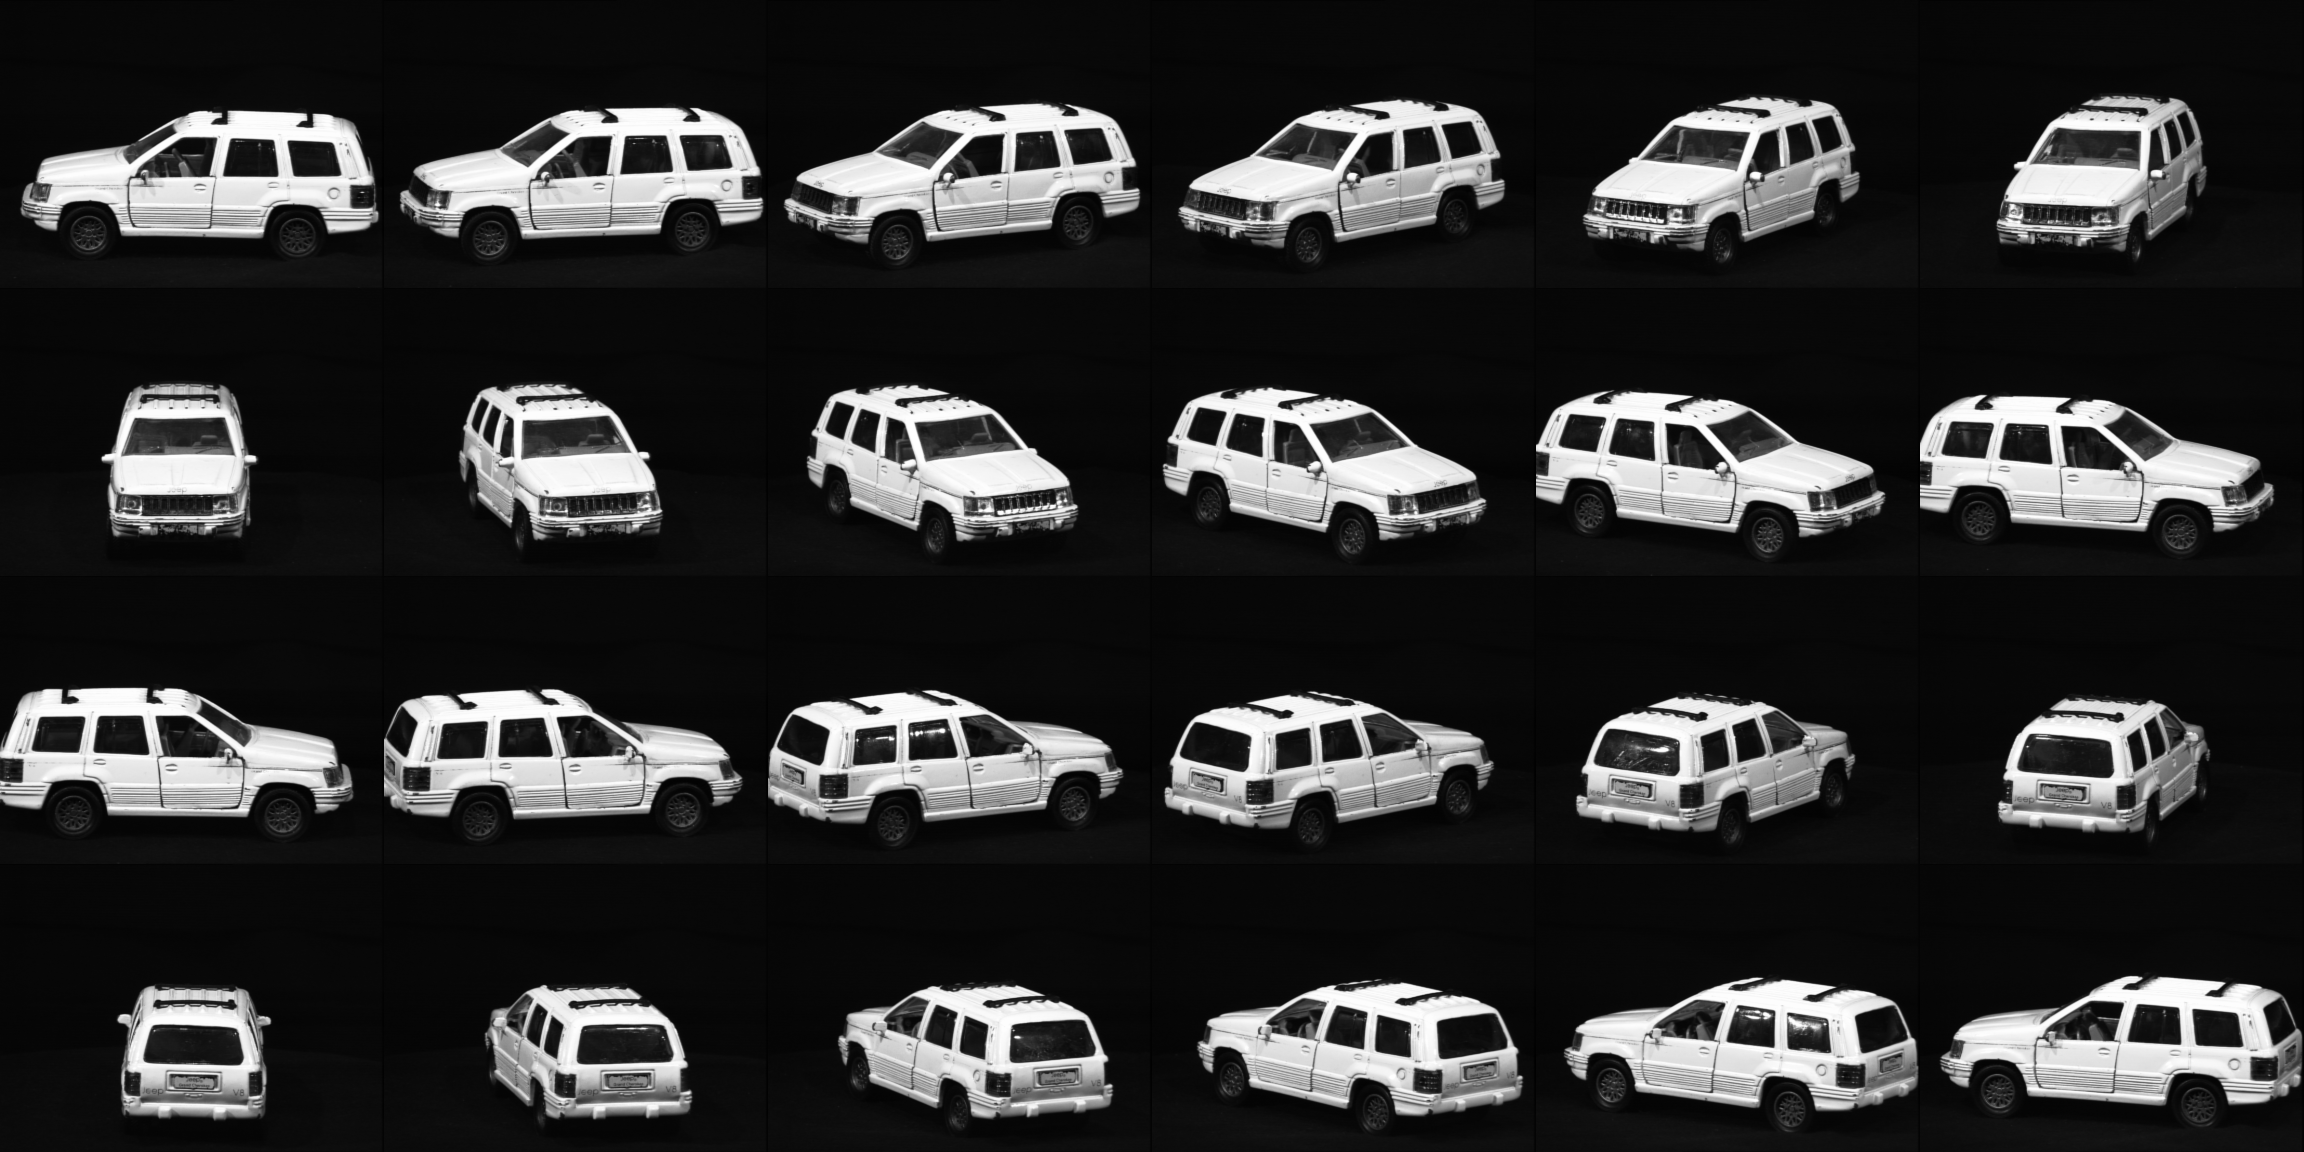

In [7]:
# get the image size
x_im,y_im = car_images_to_plot[0].size
npixels = x_im*y_im 

ncol = 6
nrow = 4
cvs = Image.new('RGB',(x_im*ncol,y_im*nrow))

for i in range(len(car_images_to_plot)):
    px, py = x_im*(i%ncol), y_im*int(i/ncol)
    cvs.paste(car_images_to_plot[i],(px,py)) 
cvs

Car data and center

In [8]:
X = np.asmatrix(X)
m = X.mean(axis=0)
X = X - m
X = X.T

color = np.arange(0,360,5) # colours for each image

In [9]:
(n,p) = np.shape(X)
r = 72
print(f'n = {n}')
print(f'p = {p}')

n = 72
p = 110592


Calculate the PC scores

* NB factor of $p^{-1/2}$ included in $\zeta$ - see main consistency theorem 

In [10]:
zeta, s = pc_scores(X,r-1, return_eig = True)
zeta = p **-.5 * zeta

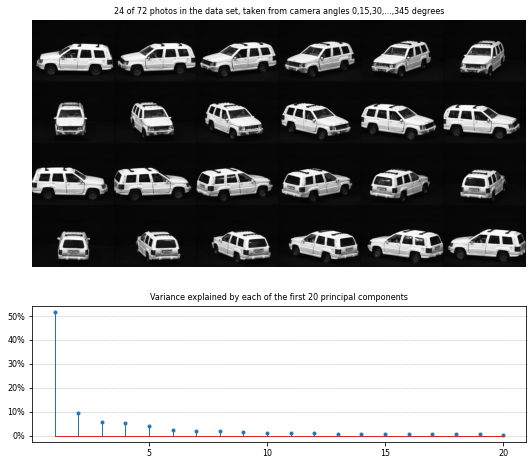

In [11]:
image = cvs

fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(7.5, 7.5)

ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('24 of 72 photos in the data set, taken from camera angles 0,15,30,...,345 degrees',fontsize = 8)

r_plot = 20
percent_var = s[0:r_plot]**2/sum(s**2)

markerline, stemline, baseline, = ax[1].stem(range(1,r_plot+1),100*percent_var)
ax[1].set_xticks([5,10,15,20])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax[1].grid(axis='y', linestyle='--', linewidth=0.5)
ax[1].set_title('Variance explained by each of the first 20 principal components', fontsize = 8)

plt.setp(stemline, linewidth = 1)
plt.setp(markerline, markersize = 3)
plt.setp(baseline, linewidth = 1)

fig.subplots_adjust(hspace=-.2)
fig.tight_layout()

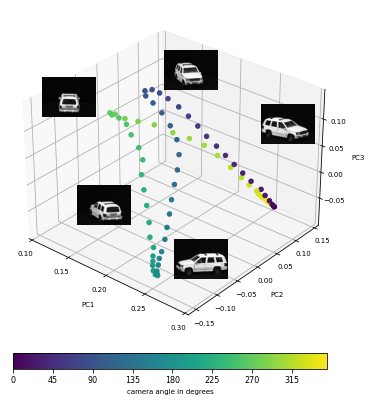

In [12]:
fig = plt.figure(figsize=(7.5,7.5))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(zeta[:,0], zeta[:,1], zeta[:,2],  marker='o', c=color, cmap='viridis', alpha=1) 
ax.set_xlabel('PC1', labelpad=0.5)
ax.set_ylabel('PC2', labelpad=0.5)
ax.set_zlabel('PC3', labelpad=0.5)

elev = 30.0
azim = 310.0
ax.view_init(elev, azim)
ax.set_xlim(0.1,0.3)
ax.set_xticks([0.1,0.15,0.2,0.25,0.3])
ax.tick_params(axis='x', pad=0.3, labelsize = 'x-small')
ax.tick_params(axis='y', pad=0.3, labelsize = 'x-small')
ax.tick_params(axis='z', pad=0.3, labelsize = 'x-small')

# each time the SVD is calculated it may return different signs of the singular vectors
# corresponding to some orthogonal transformation of the PC scores - so need to place below images accordingly

arr_image = plt.imread('./car images/160_r140.png', format='png')
newax = fig.add_axes([0.68, 0.6, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

arr_image = plt.imread('./car images/160_r15.png', format='png')
newax = fig.add_axes([0.52, 0.35, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

arr_image = plt.imread('./car images/160_r290.png', format='png')
newax = fig.add_axes([0.34, 0.45, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

arr_image = plt.imread('./car images/160_r105.png', format='png')
newax = fig.add_axes([0.5, 0.7, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')

arr_image = plt.imread('./car images/160_r270.png', format='png')
newax = fig.add_axes([0.275, 0.65, 0.1, 0.1], anchor='NE')
newax.imshow(arr_image/255.0, cmap='gray')
newax.axis('off')


fig.colorbar(im, ax=ax, shrink=0.75, location='bottom', pad = 0.05, label='camera angle in degrees', ticks=[0,45,90,135,180,225,270,315,360]);

The first three dimensions of the PC scores appear around a loop which is somewhat irregular in shape but resembles the circle of camera positions, subject to deformation by bending and twisting. The PC scores appear roughly equally spaced around the loop, resembling the geometry of the camera positions which are equally spaced at intervals of 5 degrees around a circle, supporting the intuitive explanation of apparent manifold structure in this data.

In [13]:
print('Variance explained by the first 20 principle components ' + str(np.sum(100*percent_var[0:20])))

Variance explained by the first 20 principle components 91.49314175788155


# PCA vs PCA + t-SNE: Newsgroups example  

In other situations, PCA into three dimensions may not be enough to reveal much about the topological and geometric structure of some datasets. In this section, we look at the difference between, first, applying PCA and then applying PCA and t-SNE to the Newsgroup dataset.

Data load and sort

In [14]:
newsgroups = fetch_20newsgroups()
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [15]:
## create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(lambda row: newsgroups["target_names"][row])

In [16]:
## list of common words to delete
stopword = set(nltk.corpus.stopwords.words("english"))
stopword.update(['subject'])

In [17]:
## gets rid of email addresses  in data
df["data_str"] = df.data.apply(lambda row: del_email_address(row))
# gets rid of stopwords, symbols, makes lower case and base words
df["data_str"] = df.data_str.apply(lambda row: clean_text(row))

In [18]:
## use random sample of data 
s_df = df.sample(n=7500, replace=False, random_state=22).reset_index(drop=True)

In [19]:
## vectorize data
vectorizer = TfidfVectorizer()
Y = vectorizer.fit_transform(s_df.data_str)

PC scores

In [20]:
(n,p) = Y.shape
print(n,p)

7500 75879


In [21]:
## pca to 20 dimensions
zeta = p**-.5 * pc_scores(Y, 20)

In [22]:
zeta_df = pd.DataFrame(zeta[:,:2])
zeta_df["target"] = np.array(s_df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)

In [23]:
tsne_zeta = TSNE(n_components=2, perplexity = 30).fit_transform(zeta)

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


It is of note that the default initialization of $t$-SNE is changing to PCA in 1.2 -- our theory provides statistical justification on why this is a good way to bring dimension from high to moderate before using nonlinear dimension reduction. 

In [24]:
tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(s_df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

In [25]:
# colours - topics from the same theme have different shades of the same colour

target_colour = {'alt.atheism' : 'goldenrod',
 'comp.graphics' : 'steelblue',
 'comp.os.ms-windows.misc': 'skyblue',
 'comp.sys.ibm.pc.hardware' : 'lightblue',
 'comp.sys.mac.hardware' : 'powderblue',
 'comp.windows.x' : 'deepskyblue',
 'misc.forsale' : 'maroon',
 'rec.autos' : 'limegreen',
 'rec.motorcycles' : 'green',
 'rec.sport.baseball' : 'yellowgreen',
 'rec.sport.hockey' : 'olivedrab',
 'sci.crypt' : 'pink',
 'sci.electronics' : 'plum',
 'sci.med' : 'orchid',
 'sci.space' : 'palevioletred',
 'soc.religion.christian' : 'darkgoldenrod', 
 'talk.politics.guns' : 'coral',
 'talk.politics.mideast' : 'tomato',
 'talk.politics.misc' : 'darksalmon',
 'talk.religion.misc' : 'gold'}

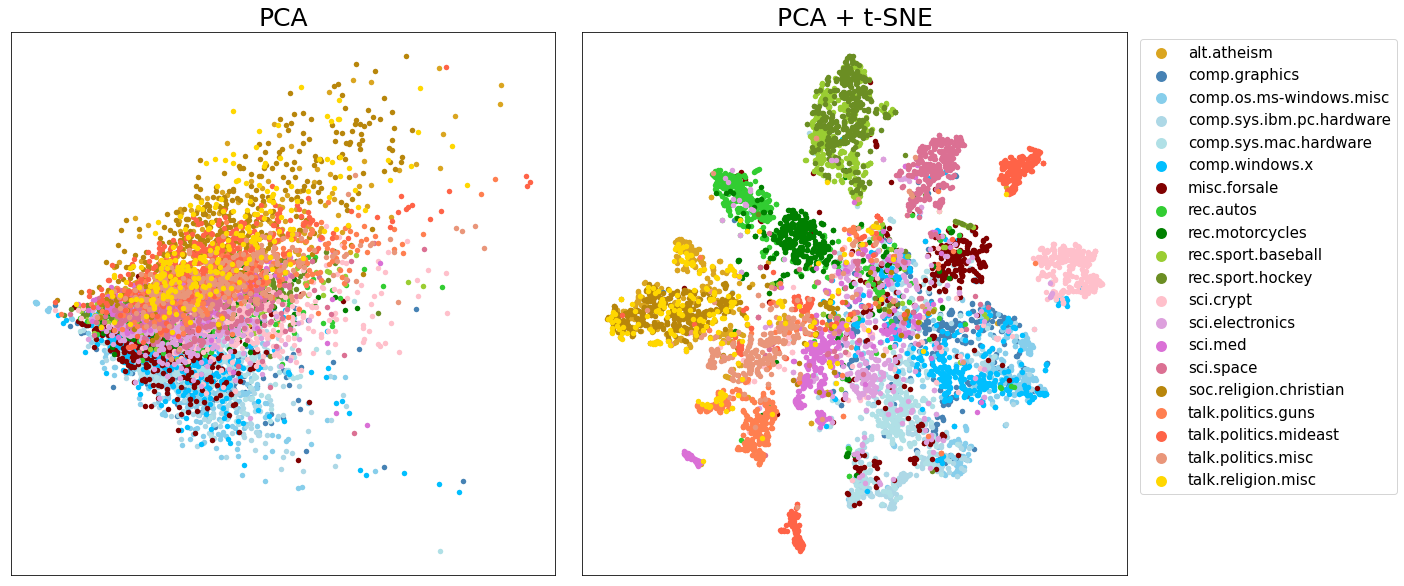

In [26]:
## plot after applying PCA lhs and after applying PCA then t-SNE on the rhs

fig,ax = plt.subplots(1,2,figsize = (20,10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0],t_df[1], marker = 'o',edgecolor='black', linewidth=0,s = 30,label = t,c= target_colour[t]);
ax[0].set_title(f'PCA',fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0],t_df[1], marker = 'o',edgecolor='black', linewidth=0,s = 30,label = t, alpha = 1,c= target_colour[t]);
ax[1].set_title(f'PCA + t-SNE',fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(1.51, 1) ,prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

#fig.savefig(f"newsgroup.pdf", bbox_inches='tight')

When using PCA to reduce to 2 dimensions, documents associated with distinct newsgroups are not clearly separated, whereas applying PCA to 20 dimensions followed by $t$-SNE is much more effective in revealing newsgroup clusters. It is clear that posts on similar topics are clustered together, for example, the yellow and browns are posts on religion and greens are posts on recreation -- further, the recreation topics are in three clusters: autos, motorcycles and sport.